This notebook contains the statistical analysis of the author-members of Shakespeare and Company. It consists of two parts: nationalities and book per authors. The first part is a simple analysis of the nationalities of the authors, while the second part is a more complex analysis of the number of books written by each author.

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import entropy
import numpy as np

The following code imports the `sort_names` function from `utils.py`, which is used to sort the names of the author-members in the dataset. The function is stored in a separate file to keep the notebook clean and readable as it is used across multiple notebooks.

In [28]:
from utils import sort_names

Now the `member_is_author` DataFrame created in the previous notebook (01_intersection.ipynb) is loaded. It includes the names of the author-members and corresponding information. Moreover, the `books` DataFrame from Princeton University's Shakespeare and Company Project is loaded. It contains information about the books in the library of Shakespeare and Company.

In [29]:
member_is_author = pd.read_csv('../data/processed/table-data/01_member_is_author.csv', encoding='utf-8')
books = pd.read_csv('../data/raw/SCoData_books_v1.2_2022_01.csv', encoding='utf-8', dtype={'year': 'Int32'})

In [30]:
member_is_author.columns

Index(['uri', 'name', 'sort_name', 'title', 'gender', 'is_organization',
       'has_card', 'birth_year', 'death_year', 'membership_years', 'viaf_url',
       'wikipedia_url', 'nationalities', 'addresses', 'postal_codes',
       'arrondissements', 'coordinates', 'notes', 'updated'],
      dtype='object')

In [31]:
books.columns

Index(['uri', 'title', 'author', 'editor', 'translator', 'introduction',
       'illustrator', 'photographer', 'year', 'format', 'uncertain',
       'ebook_url', 'volumes_issues', 'notes', 'event_count', 'borrow_count',
       'purchase_count', 'circulation_years', 'updated'],
      dtype='object')

## Statistical Analysis

The statistical analysis involves the nationalities distribution of the author-members. The following steps will be performed:
* Calculation of the distribution
* Visualization
* Mode
* Entropy

### Nationalities

In [32]:
member_is_author.nationalities.sample(3)

58    United Kingdom
62    United Kingdom
34    United Kingdom
Name: nationalities, dtype: object

In [33]:
# Create a copy of the original DataFrame for processing
member_is_author_nationalities_df = member_is_author.copy()

# Replace missing values in the 'nationalities' column with the placeholder 'Unknown'
member_is_author_nationalities_df['nationalities'] = member_is_author_nationalities_df['nationalities'].fillna('Unknown')

# Split the 'nationalities' column into multiple columns using ';' as the delimiter
split_nationalities_df = member_is_author_nationalities_df['nationalities'].str.split(';', expand=True)

# Stack the resulting DataFrame so that each nationality appears in its own row
stacked_nationalities_series = split_nationalities_df.stack()\
    .reset_index(level=1, drop=True)\
    .rename('nationalities')

# Drop the original 'nationalities' column and join the stacked nationalities
nationalities_df = member_is_author_nationalities_df.drop('nationalities', axis=1).join(stacked_nationalities_series)

# Display the resulting DataFrame
print(nationalities_df.head(5))

                                                 uri                  name  \
0  https://shakespeareandco.princeton.edu/members...     Richard Aldington   
1  https://shakespeareandco.princeton.edu/members...  Margaret C. Anderson   
2  https://shakespeareandco.princeton.edu/members...        George Antheil   
3  https://shakespeareandco.princeton.edu/members...          Louis Aragon   
4  https://shakespeareandco.princeton.edu/members...           Nathan Asch   

               sort_name title  gender  is_organization  has_card  birth_year  \
0     Aldington, Richard   NaN    Male            False      True      1892.0   
1  Anderson, Margaret C.   NaN  Female            False     False      1886.0   
2        Antheil, George   NaN    Male            False     False      1900.0   
3          Aragon, Louis   NaN    Male            False      True      1897.0   
4           Asch, Nathan   NaN    Male            False     False      1902.0   

   death_year membership_years              

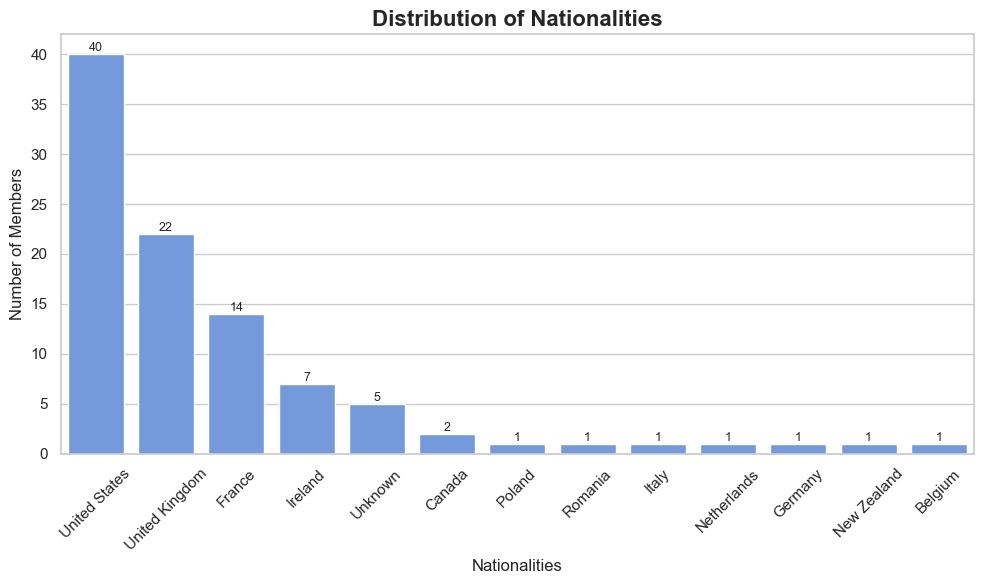

In [ ]:
nationality_counts = nationalities_df['nationalities'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=nationality_counts.index, y=nationality_counts.values, color='cornflowerblue')
plt.title('Distribution of Nationalities', fontsize=16, fontweight='bold')
plt.xlabel('Nationalities')
plt.ylabel('Number of Members')
plt.xticks(rotation=45)
for i, count in enumerate(nationality_counts.values):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../data/processed/figure-images/03_bar_nationalities_distribution.png',bbox_inches='tight')
plt.show()

In [35]:
# Group by nationality and aggregate the sort_name column
names_by_nationality_initial = (
    nationalities_df.groupby('nationalities')
    .agg({'sort_name': lambda x: sort_names(list(set(x)))})  # Deduplicate and format names
    .reset_index()
)

# Create a new GeoDataFrame that includes a column counting the number of names in each group.
names_by_nationality_with_count = names_by_nationality_initial.assign(
    count_names=lambda df: df['sort_name'].apply(lambda x: len(x.split(', ')))
)

# Create a final GeoDataFrame by sorting by the new count column in descending order.
names_by_nationality = names_by_nationality_with_count.sort_values('count_names', ascending=False).reset_index(drop=True)

print(names_by_nationality)

     nationalities                                          sort_name  \
0    United States  Allen Tate, Archibald MacLeish, Djuna Barnes, ...   
1   United Kingdom   Bryher, Anna Wickham, C. K. Ogden, Cyril Conn...   
2           France  André Gide, Eugene Jolas, Henri Michaux, Jean ...   
3          Ireland  Austin Clarke, James Joyce, Kathleen Coyle, Pa...   
4          Unknown  Elizabeth Clark, Frank Harris, Louis Bromfield...   
5           Canada                        Leon Edel, Morley Callaghan   
6          Belgium                                      Henri Michaux   
7          Germany                                    Ludwig Lewisohn   
8            Italy                                   Stanislaus Joyce   
9      Netherlands                                        Odette Keun   
10     New Zealand                                Katherine Mansfield   
11          Poland                                        Nathan Asch   
12         Romania                                 

In [36]:
# Export the DataFrame to CSV.
names_by_nationality.to_csv(
    '../data/processed/table-data/03_member_is_author_nationalities.csv',
    index=False,
    encoding='utf-8'
)

In [37]:
author_by_nationality = names_by_nationality[names_by_nationality['nationalities'] == 'Ireland']['sort_name'].unique()

print(author_by_nationality)

['Austin Clarke, James Joyce, Kathleen Coyle, Padraic Colum, Samuel Beckett, Stanislaus Joyce, Thomas MacGreevy']


In [38]:
percentages = nationalities_df['nationalities'].value_counts(normalize=True) * 100
print(percentages)

United States     41.237113
United Kingdom    22.680412
France            14.432990
Ireland            7.216495
Unknown            5.154639
Canada             2.061856
Poland             1.030928
Romania            1.030928
Italy              1.030928
Netherlands        1.030928
Germany            1.030928
New Zealand        1.030928
Belgium            1.030928
Name: nationalities, dtype: float64


English-speaking countries:

In [39]:
percentages[0] + percentages[1] + percentages[3] + percentages[5] + percentages[11]

74.22680412371135

#### Mode

In [40]:
mode_nationalities = nationalities_df['nationalities'].value_counts().idxmax() # mode
print(f"Mode of nationalities distribution: {mode_nationalities}")

Mode of nationalities distribution: United States


#### Entropy

In [41]:
def calculate_entropy(distribution):
    """
    Calculate the entropy of a given distribution.

    Parameters:
        distribution (array-like): A probability distribution for which the entropy is to be calculated.

    Returns:
        float: The entropy of the distribution.

    Raises:
        ValueError: If the distribution is not valid or if it contains negative probabilities.
    """
    return entropy(distribution)

def calculate_max_entropy(num_categories):
    """
    Calculate the maximum possible entropy for a given number of categories.

    Entropy is a measure of the uncertainty or randomness in a system. The maximum entropy is achieved when all categories are equally likely.

    Parameters:
        num_categories (int): The number of categories.

    Returns:
        float: The maximum possible entropy for the given number of categories.

    Raises:
        ValueError: If num_categories is not a positive integer.
    """
    return np.log(num_categories)

def calculate_normalized_entropy(distribution):
    """
    Calculate the normalized entropy of a given distribution.

    Normalized entropy is the ratio of the entropy of the distribution to the 
    maximum possible entropy for a distribution of the same size. This value 
    ranges from 0 to 1, where 0 indicates no entropy (completely predictable 
    distribution) and 1 indicates maximum entropy (completely unpredictable 
    distribution).

    Args:
        distribution (list or array-like): The distribution for which to 
        calculate the normalized entropy.

    Returns:
        float: The normalized entropy of the distribution.
    """
    ent = calculate_entropy(distribution)
    max_ent = calculate_max_entropy(len(distribution))
    return ent / max_ent

In [42]:
nationalities_counts = nationalities_df['nationalities'].value_counts(normalize=True)

entropy_nationalities = calculate_entropy(nationalities_counts)

max_entropy_nationalities = calculate_max_entropy(len(nationalities_counts))

normalized_entropy_nationalities = calculate_normalized_entropy(nationalities_counts)

print(f"Entropy of nationalities distribution: {entropy_nationalities}")

print(f"Maximum possible entropy with {len(nationalities_counts)} categories: {max_entropy_nationalities}")

print(f"Normalized entropy: {normalized_entropy_nationalities}")

Entropy of nationalities distribution: 1.7338886102587268
Maximum possible entropy with 13 categories: 2.5649493574615367
Normalized entropy: 0.6759933116085812


### Books per Author-Member

In [43]:
member_is_author.shape

(84, 19)

In [44]:
member_is_author.columns

Index(['uri', 'name', 'sort_name', 'title', 'gender', 'is_organization',
       'has_card', 'birth_year', 'death_year', 'membership_years', 'viaf_url',
       'wikipedia_url', 'nationalities', 'addresses', 'postal_codes',
       'arrondissements', 'coordinates', 'notes', 'updated'],
      dtype='object')

#### Overall comparison of books by members

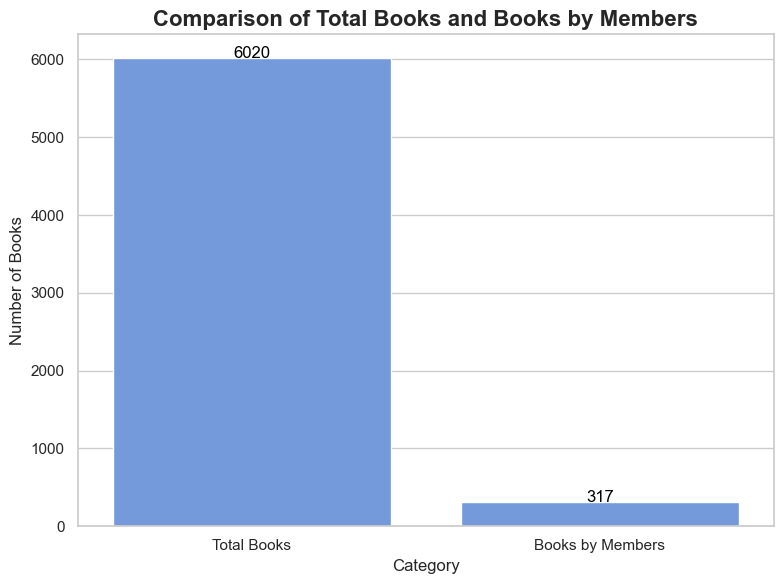

In [ ]:
books_by_member = books[books['author'].isin(member_is_author['sort_name'])]

# Calculate the number of unique titles
total_unique_titles = len(books['uri'].unique())
unique_titles_by_member = len(books_by_member['uri'].unique())

# Prepare data for plotting
data = pd.DataFrame({
    'Category': ['Total Books', 'Books by Members'],
    'Count': [total_unique_titles, unique_titles_by_member]
})

# Plot the diagram
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Category', y='Count', data=data, color='cornflowerblue')
for index, row in data.iterrows():
    barplot.text(index, row.Count, round(row.Count, 2), color='black', ha="center")
plt.ylabel('Number of Books')
plt.title('Comparison of Total Books and Books by Members', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/figure-images/03_bar_books_comparison.png',bbox_inches='tight')
plt.show()

In [46]:
# Export the DataFrame to CSV
books_by_member.to_csv(
    '../data/processed/table-data/03_member_is_author_books.csv',
    index=False,
    encoding='utf-8'
)

In [47]:
# Calculate the percentage of unique titles by members out of the total
percentage_of_books_by_members = (unique_titles_by_member / total_unique_titles) * 100

# Prepare a dictionary with the results
book_counts_summary = {
    'Total Books': total_unique_titles,
    'Books by Members': unique_titles_by_member,
    'Percentage of Books by Members': f'{percentage_of_books_by_members:.2f}%'
}

# Display the dictionary
book_counts_summary

{'Total Books': 6020,
 'Books by Members': 317,
 'Percentage of Books by Members': '5.27%'}

#### How many books does each author have?

In [48]:
# Group the filtered DataFrame by 'author' and count the number of titles for each author
books_count_by_author = books_by_member.groupby('author').count()['title'].sort_values(ascending=False)

# Optionally, reset the index
books_count_by_author = books_count_by_author.reset_index()
books_count_by_author.columns = ['author', 'numberOfBooks']

# Display the result
print(books_count_by_author)

books_count_by_author.numberOfBooks.sum()

                      author  numberOfBooks
0           Ford, Ford Madox             18
1                Pound, Ezra             16
2               Joyce, James             14
3          Hemingway, Ernest             11
4           Bromfield, Louis             11
..                       ...            ...
79        Bishop, John Peale              1
80             Beach, Sylvia              1
81  Barney, Natalie Clifford              1
82            McKenney, Ruth              1
83          de Lanux, Pierre              1

[84 rows x 2 columns]


317

In [49]:
# Calculate the total number of books
total_books_member = books_count_by_author['numberOfBooks'].sum()

# Calculate the percentage of books per author
books_count_by_author['percentage'] = (books_count_by_author['numberOfBooks'] / total_books_member) * 100

# Display the result
books_count_by_author.loc[books_count_by_author['author'] == 'Tate, Allen']

,author,numberOfBooks,percentage
22,"Tate, Allen",5,1.577287


In [50]:
# Count the number of rows where numberOfBooks is 1
rows_with_one_book = books_count_by_author[books_count_by_author['numberOfBooks'] == 1].shape[0]

# Calculate the percentage
total_rows = len(books_count_by_author)
percentage_rows_with_one_book = (rows_with_one_book / total_rows) * 100

# Display the result
percentage_rows_with_one_book

36.904761904761905

In [51]:
highest_books_count = books_count_by_author.nlargest(23, 'numberOfBooks')

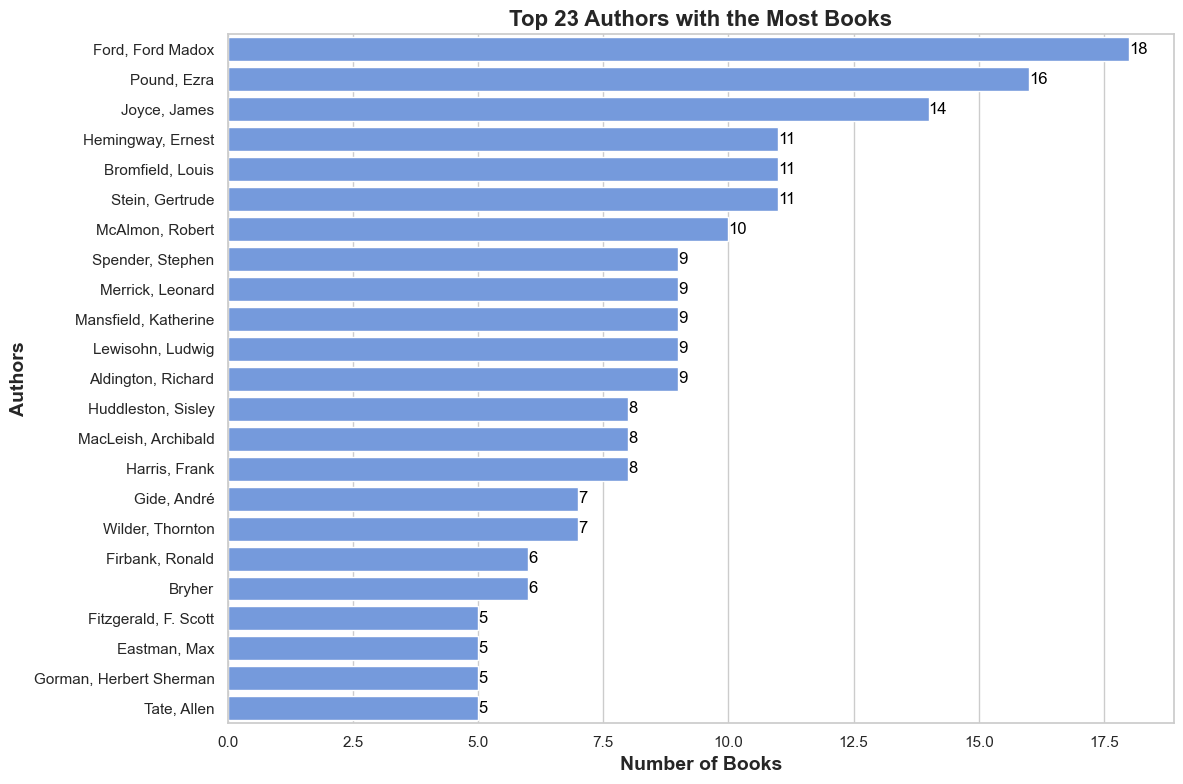

In [ ]:
# Create the plot with a modern style
plt.figure(figsize=(12, 8))  # Set the figure size
sns.set(style="whitegrid")  # Set the seaborn style

# Create the bar plot
bar_plot = sns.barplot(x='numberOfBooks', y='author', data=highest_books_count, color='cornflowerblue')

# Add labels and title with improved styling
plt.xlabel('Number of Books', fontsize=14, fontweight='bold')
plt.ylabel('Authors', fontsize=14, fontweight='bold')
plt.title('Top 23 Authors with the Most Books', fontsize=16, fontweight='bold')

# Add values on the bars for better readability
for index, value in enumerate(highest_books_count['numberOfBooks']):
    bar_plot.text(value, index, f'{value}', color='black', ha="left", va="center", fontsize=12)

plt.tight_layout()
plt.savefig('../data/processed/figure-images/03_bar_top_authors_books.png',bbox_inches='tight')
plt.show()